# Proyecto de Clustering "Agrupador De Pokémones"

El carácter de este proyecto es nétamente educativo, su objetivo es hacer una demostración paso a paso de cómo entrenar un modelo de aprendizaje no supervisado para la agrupación de datos similares de un Dataset utilizando la clase KMeans de la librería Scikit-Learn.

El Dataset que utilizaremos está contenido dentro de esta carpeta como 'Pokemon.csv'; la descripción de este Dataset y sus variables tambien se encuentra en esta carpeta como 'Pokemon_summary.txt'. El archivo 'Pokemon.csv' fue adaptado de: https://www.kaggle.com/datasets/rounakbanik/pokemon

La razón por la que utilizaremos este Dataset es porque es relativamente pequeño (1072 datos); fácil de entender y explicar; presenta datos de tipo String, Int, y categóricos; y requiere de preprocesamiento, pues tiene algunos errores de inputación y datos atípicos.

Por favor familiarícese tanto con la forma del Dataset como con su archivo de explicación antes de iniciar.

## 1. Preprocesamiento


Iniciaremos haciendo un analisis exploratorio de los datos: cargaremos el DataFrame, revisaremos que los tipos de los datos estén bien cargados, y si hay datos faltantes en el dataset tomaremos decisiones respecto a estos.

Posteriormente a esto revisaremos las variables numéricas más a fondo para buscar datos atípicos y encontrar una explicación para estos (por ejemplo, datos mal escritos o datos diferentes por diseño).

### 1.1 Variables categóricas y tipo String

Empecemos cargando el DataFrame y analizando los tipos de datos que Pandas asignó a cada variable.

In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


# Ignoramos las alertas de versión para mayor legibilidad
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/Pokemon.csv')

# Asignamos un valor 'seed' para reproducibilidad
np.random.seed(42)

print('Tipos de las columnas leídos por Pandas\n')
print(df.info())

Tipos de las columnas leídos por Pandas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   number      1072 non-null   int64 
 1   name        1072 non-null   object
 2   type1       1072 non-null   object
 3   type2       574 non-null    object
 4   total       1072 non-null   int64 
 5   hp          1072 non-null   int64 
 6   attack      1072 non-null   int64 
 7   defense     1072 non-null   int64 
 8   sp_attack   1072 non-null   int64 
 9   sp_defense  1072 non-null   int64 
 10  speed       1072 non-null   int64 
 11  generation  1072 non-null   int64 
 12  legendary   1072 non-null   bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 101.7+ KB
None


En este caso **teniendo en cuenta el material de orígen**, sabemos que las variables 'type1', 'type2', y 'generation' deberían ser categóricas,  no tipo object ni int64.

Sin embargo, trabajar con variables de tipo categóricas es complicado, por lo tanto, primero les realizaremos todas las transformaciones y el preprocesamiento necesario, después de hecho todo esto, las pasaremos a tipo categórico para ahorrar espacio de almacenamiento (esto se explicará más adelante).

Por lo tanto, primero realizacemos un análisis a estas y apliquemos los cambios necesarios.

In [2]:
# Estandarizamos la escritura de los datos tipo String
df['name'] = df['name'].str.title()
df['type1'] = df['type1'].str.title()
df['type2'] = df['type2'].str.title()

print('\nAnalisis de las columnas de texto:\n')
print('Datos únicos de name:', len(df.name.unique()),
      '\nDatos únicos de type1:', len(df.type1.unique()),
      '\nDatos únicos de type2:', len(df.type2.unique()),
      '\nDatos únicos de generation:', len(df.generation.unique()))

print('\nDatos únicos de type1, type2 y generation:\n')
print(df['type1'].value_counts(), '\n')
print(df['type2'].value_counts(), '\n')
print(df['generation'].value_counts())


Analisis de las columnas de texto:

Datos únicos de name: 1072 
Datos únicos de type1: 20 
Datos únicos de type2: 19 
Datos únicos de generation: 9

Datos únicos de type1, type2 y generation:

type1
Water        136
Normal       117
Grass         94
Bug           83
Psychic       80
Fire          67
Electric      63
Rock          60
Dark          48
Fighting      45
Ghost         43
Poison        42
Ground        42
Dragon        41
Steel         39
Ice           38
Fairy         23
Flying         9
Blastoise      1
Graass         1
Name: count, dtype: int64 

type2
Flying      114
Fairy        44
Psychic      43
Poison       41
Ground       39
Steel        36
Dragon       35
Fighting     32
Grass        29
Dark         28
Ghost        26
Water        22
Ice          19
Fire         18
Rock         16
Normal       11
Electric     11
Bug          10
Name: count, dtype: int64 

generation
1    178
5    166
3    160
8    139
4    121
7    114
2    106
6     85
0      3
Name: count, dtype

Analizando los datos únicos resultantes de ambas columnas, encontramos varios problemas:

* 'type2' tiene una gran cantidad de datos faltantes.
* 'type1' tiene datos mal escritos.
* 'generation' tiene un valor 0 (las generaciones de Pokémon empiezan por la 1).
* 'name' tiene dos datos repetidos (No tocaremos esto, pues los datos repetidos de 'name' coincidencialmente son los datos que tienen 'type1' mal escrito)

Primero lidiaremos con los datos faltantes de type2.

Un analisis del dataset y de su material de origen revela que los datos faltantes no son aleatorios: un dato faltante en type2 significa que el pokemon no tiene un tipo secundario, por lo tanto, imputaremos los datos faltantes como una nueva categoría "None".

**SIEMPRE es importante, antes de iniciar con un análisis de datos exploratorio, familiarizarse con el Dataset**, es gracias a esto que supimos diferenciar los datos categóricos de los numéricos, y es por esto que sabemos que 'type2' no tiene valores faltantes aleatorios.

In [3]:
df['type2'] = df['type2'].fillna('None')
print(df['type2'].value_counts())

type2
None        498
Flying      114
Fairy        44
Psychic      43
Poison       41
Ground       39
Steel        36
Dragon       35
Fighting     32
Grass        29
Dark         28
Ghost        26
Water        22
Ice          19
Fire         18
Rock         16
Normal       11
Electric     11
Bug          10
Name: count, dtype: int64


Para 'type1' , eliminaremos todas las entradas que están mal escritas. Encontrar datos mal escritos puede ser complicado en Datasets de gran tamaño, generalmente requiere de la aplicación de algoritmos de aprendizaje de máquina relacionados con similitud de texto como los que utilizan los auto-correctores de los celulares.

Sin embargo, en este caso sabemos que los datos de 'type1' pertenecen a categorías limitadas, con lo que una categoría que tenga tan solo uno o dos miembros muy probablemente será un error.

Considerando esto, eliminaremos todos los datos que contengan un valor de 'type1' que se repita menos de 5 veces (valor escogido arbitrariamente).

In [4]:
categories = df['type1'].value_counts()
categories = categories[categories[categories.index] > 5]

df = df[df['type1'].isin(categories.index)]

print(df['type1'].value_counts())

type1
Water       136
Normal      117
Grass        94
Bug          83
Psychic      80
Fire         67
Electric     63
Rock         60
Dark         48
Fighting     45
Ghost        43
Poison       42
Ground       42
Dragon       41
Steel        39
Ice          38
Fairy        23
Flying        9
Name: count, dtype: int64


Finalmente, revisaremos los datos categorizados como 'generación 0', pues no existe una generación 0 en Pokémon.

In [5]:
print(df[df['generation'] == 0])

     number                 name  type1 type2  total   hp  attack  defense  \
950     808               Meltan  Steel  None    300   46      65       65   
951     809             Melmetal  Steel  None    600  135     143      143   
952     809  Gigantamax Melmetal  Steel  None    600  135     143      143   

     sp_attack  sp_defense  speed  generation  legendary  
950         55          35     34           0       True  
951         80          65     34           0       True  
952         80          65     34           0       True  


Investigando, encontramos que este Pokémon (y sus dos variables también aquí presentes) fue introducido en un videojuego secundario de la saga, no en uno de los principales, con lo que el DataFrame clasifica su generación como 0. Sin embargo, de acuerdo a la wiki del juego, el videojuego en el que fue introducido está situado en la septima generación, por lo tanto, le imputaremos este valor.

In [6]:
df['generation'].replace(0, 7, inplace=True)

print(df['generation'].value_counts())

generation
1    177
5    166
3    160
8    138
4    121
7    117
2    106
6     85
Name: count, dtype: int64


Si una variable de texto consiste en unos pocos valores que se repite muchas veces, es buena idea pasarla a tipo categórica, pues este tipo de variable consume mucho menos espacio en memoria que variables String, pues está optimizando para datos que se repiten.

Teniendo esto en cuenta, convertiremos 'type1', 'type2' y 'generation' a variables categóricas para reducir su consumo de almacenamiento (no convertiremos 'name' a categórico debido a que ninguno de sus datos se repite, con lo que la ganancia de espacio de almacenamiento sería trivial).

In [7]:
df['type1'] = df['type1'].astype('category')
df['type2'] = df['type2'].astype('category')
df['generation'] = df['generation'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070 entries, 0 to 1071
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   number      1070 non-null   int64   
 1   name        1070 non-null   object  
 2   type1       1070 non-null   category
 3   type2       1070 non-null   category
 4   total       1070 non-null   int64   
 5   hp          1070 non-null   int64   
 6   attack      1070 non-null   int64   
 7   defense     1070 non-null   int64   
 8   sp_attack   1070 non-null   int64   
 9   sp_defense  1070 non-null   int64   
 10  speed       1070 non-null   int64   
 11  generation  1070 non-null   category
 12  legendary   1070 non-null   bool    
dtypes: bool(1), category(3), int64(8), object(1)
memory usage: 89.5+ KB


### 1.2 Datos repetidos

Como observamos anteriormente cuando analizamos la 'generación 0' con Melmetal y Gigantamax Melmetal, algunos pokémones tienen variantes con exactamente las mismas características e, incluso, el mísmo número de registro 'number'. Observemos esto más a fondo.

In [8]:
print(df[df.duplicated(subset='number', keep=False)].head(7))

    number                  name  type1   type2  total  hp  attack  defense  \
2        3              Venusaur  Grass  Poison    525  80      82       83   
3        3         Mega Venusaur  Grass  Poison    625  80     100      123   
4        3   Gigantamax Venusaur  Grass  Poison    525  80      82       83   
7        6             Charizard   Fire  Flying    534  78      84       78   
8        6      Mega Charizard X   Fire  Dragon    634  78     130      111   
9        6      Mega Charizard Y   Fire  Flying    634  78     104       78   
10       6  Gigantamax Charizard   Fire  Flying    534  78      84       78   

    sp_attack  sp_defense  speed generation  legendary  
2         100         100     80          1      False  
3         122         120     80          1      False  
4         100         100     80          1      False  
7         109          85    100          1      False  
8         130          85    100          1      False  
9         159         115

Podemos observar que las versiones 'Mega' de los pokémones tienen estadisticas e, incluso, tipos diferentes, con lo que no pueden ser consideradas datos repetidos. Sin embargo, las versiones 'Gigantamax' tienen exactamente las mismas estadísticas y tipos.

Considerando esto, nos desharemos de todos los datos que coincidan en 'number' y todas sus estadísticas de combate (desde 'type1' hasta 'speed'), pues para propósitos de entrenamiento son simplemente datos repetidos.

In [9]:
# Creamos una lista con las columnas que no queremos tener duplicadas
dup_cols = list(df.loc[0, 'type1':'speed'].index)
dup_cols.append('number')

# Conservamos el primer dato, pues este es el Pokémon 'original'
df.drop_duplicates(subset=dup_cols, keep='first', inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1034 entries, 0 to 1071
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   number      1034 non-null   int64   
 1   name        1034 non-null   object  
 2   type1       1034 non-null   category
 3   type2       1034 non-null   category
 4   total       1034 non-null   int64   
 5   hp          1034 non-null   int64   
 6   attack      1034 non-null   int64   
 7   defense     1034 non-null   int64   
 8   sp_attack   1034 non-null   int64   
 9   sp_defense  1034 non-null   int64   
 10  speed       1034 non-null   int64   
 11  generation  1034 non-null   category
 12  legendary   1034 non-null   bool    
dtypes: bool(1), category(3), int64(8), object(1)
memory usage: 86.6+ KB
None


### 1.3 Datos atípicos

Ahora, por medio del método de rango intercuartílico, buscaremos datos con características anormales que puedan ser considerados datos atípicos en cada una de las columnas de tipo Int, por medio de un for loop.

El **Rango Intercuartílico** es una medida de dispersión estadística utilizada para encontrar datos lo suficientemente alejados de la media como para ser considerados atípicos. Se define como 'la diferencia entre el tercer y el primer cuartil de una distribución'. Si un dato está 1.5 rangos intercuartílicos alejado de la media de la distribución, es considerado un dato atípico o extremo.

**Para la busqueda de datos atípicos, ignoraremos a los Pokémones legendarios, pues estos son atípicos por diseño y son esenciales para el modelo.**

In [10]:
atipicos = list()

df_no_leg = df[df['legendary'] == False]

for column in (df.loc[0, 'total':'speed'].index):
  # Calculamos el IQR y los limites superior e inferior
  iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
  low_iqr = df[column].quantile(0.25) - (1.5 * iqr)
  high_iqr = df[column].quantile(0.75) + (1.5 * iqr)

  # Guardamos los datos que se salgan de este rango
  atipicos.append(list(df_no_leg[(df_no_leg[column] < low_iqr) |
                                 (df_no_leg[column] > high_iqr)].index))

# Desempacamos la lista de listas en una sola lista de valores únicos
atipicos = sorted(list(itertools.chain(*atipicos)))

print('Cantidad de datos atípicos:', len(atipicos))
print(df[df.index.isin(atipicos)])

Cantidad de datos atípicos: 39
     number            name     type1     type2  total   hp  attack  defense  \
57       40      Wigglytuff    Normal     Fairy    435  140      70       45   
89       65   Mega Alakazam   Psychic      None    590   55      50       65   
113      80    Mega Slowbro     Water   Psychic    590   95      75      180   
127      91        Cloyster     Water       Ice    525   50      95      180   
131      94     Mega Gengar     Ghost    Poison    600   60      65       80   
133      95            Onix      Rock    Ground    385   35      45      160   
155     113         Chansey    Normal      None    450  250       5        5   
177     131          Lapras     Water       Ice    535  130      85       80   
182     134        Vaporeon     Water      None    525  130      65       60   
192     143         Snorlax    Normal      None    540  160     110       65   
237     181   Mega Ampharos  Electric    Dragon    610   90      95      105   
259     2

En este caso, podemos observar que ninguno de los 39 datos atípicos se origina de un error de escritura (ni siquiera el de Shedinja, quien solo tiene 1 punto de vida), sino que son datos leales al juego; aún así, incluirlos en los datos de entrenamiento puede afectar negativamente las medidas de tendencia central de nuestro Dataset e introducir ruido a nuestro modelo, por lo tanto, los eliminaremos de nuestro Dataset de entrenamiento, pero los mantendremos en un Dataset diferente para luego usarlos en las predicciones.


In [11]:
df_original = df.copy()

df = df[~df.index.isin(atipicos)]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 0 to 1071
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   number      996 non-null    int64   
 1   name        996 non-null    object  
 2   type1       996 non-null    category
 3   type2       996 non-null    category
 4   total       996 non-null    int64   
 5   hp          996 non-null    int64   
 6   attack      996 non-null    int64   
 7   defense     996 non-null    int64   
 8   sp_attack   996 non-null    int64   
 9   sp_defense  996 non-null    int64   
 10  speed       996 non-null    int64   
 11  generation  996 non-null    category
 12  legendary   996 non-null    bool    
dtypes: bool(1), category(3), int64(8), object(1)
memory usage: 83.4+ KB
None


Anteriormente no incluímos a los legendarios en nuestro análisis, pero si graficamos los datos (incluyendo a los legendarios) encontramos un problema bastante grande.

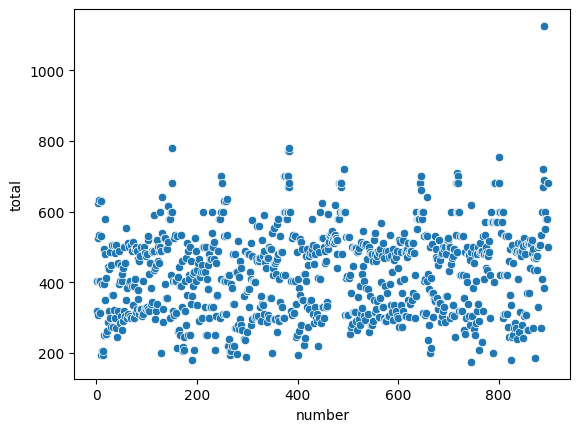

In [12]:
sns.scatterplot(x='number', y='total', data=df)
plt.show()

Este dato atípico incluso entre los legendarios es Eternamax Eternatus (lo encontraremos si visualizamos la lista ordenada de forma descendente en su valor 'total'). Sus estadísticas duplican a la mayoría de otros Pokémones, legendarios incluidos.

Este dato será eliminado tanto del DataFrame de entrenamiento como del original (luego usaremos el original para analizar medidas de tendencia central), pues solo existe en los juegos como un enemigo y su objetivo es ser extremadamente fuerte, mantenerlo en el DataFrame podría afectar negativamente a nuestro modelo y no nos aportará nada. **En caso de que quisieramos clasificarlo luego de entrenado el modelo, podríamos tomar sus datos y usar el modelo para hacer una predicción**, pero no nos es útil como dato de entrenamiento.

In [13]:
print('DataFrame antes de borrar el valor atípico:\n\n',
      df.sort_values('total', ascending=False), '\n')

df.drop(1057, inplace=True)
df_original.drop(1057, inplace=True)

print('DataFrame después de borrar el valor atípico:\n\n', df.sort_values('total', ascending=False))

DataFrame antes de borrar el valor atípico:

       number                   name    type1     type2  total   hp  attack  \
1057     890    Eternamax Eternatus   Poison    Dragon   1125  255     115   
471      384          Mega Rayquaza   Dragon    Flying    780  105     180   
205      150          Mega Mewtwo Y  Psychic      None    780  106     150   
204      150          Mega Mewtwo X  Psychic  Fighting    780  106     190   
469      383         Primal Groudon   Ground      Fire    770  100     180   
...      ...                    ...      ...       ...    ...  ...     ...   
367      298                Azurill   Normal     Fairy    190   50      20   
1031     872                   Snom      Ice       Bug    185   30      25   
247      191                Sunkern    Grass      None    180   30      30   
971      824                Blipbug      Bug      None    180   25      20   
883      746  Wishiwashi Solo Forme    Water      None    175   45      20   

      defense  sp

Por último, mezclaremos los datos para que no estén ordenados por generación.

Si no hacemos esto, el modelo podría aprender tendencias que sean resultado de los cambios en los datos con el tiempo y, aunque esto pueda ser interesante **en otros modelos** para responder algunas preguntas sobre la forma en que los datos han cambiado con los años, para KMeans puede introducir un prejuicio innecesario y posiblemente dañino.

Como al inicio del proyecto se configuró un valor 'seed', el DataFrame mezclado **siempre debe ser el mismo** la primera vez que se corra el código.

In [14]:
df = df.sample(frac=1).reset_index(drop=True)
print(df.head())

   number        name   type1 type2  total  hp  attack  defense  sp_attack  \
0     831      Wooloo  Normal  None    270  42      40       55         40   
1     470     Leafeon   Grass  None    525  65     110      130         60   
2     504      Patrat  Normal  None    255  45      55       39         35   
3     588  Karrablast     Bug  None    315  50      75       45         40   
4     564    Tirtouga   Water  Rock    355  54      78      103         53   

   sp_defense  speed generation  legendary  
0          45     48          8      False  
1          65     95          4      False  
2          39     42          5      False  
3          45     60          5      False  
4          45     22          5      False  


Con esto termina la sección de preprocesamiento.

## 2. Preparación y entrenamiento del modelo

### 2.1 Reducción de dimensionalidad

Para el algoritmo de K-Means es ideal reducir la dimensionalidad del DataFrame, pues una dimensionalidad alta puede llevar a tiempos de ejecución muy altos y, peor aún, puede restarle significancia a las características importantes, dándole prioridad al ruido.

Es por esto que debemos analizar las dimensiones de nuestros datos e intentar reducirlas lo más posible. En este caso, lo haremos por medio de un análisis de correlación: si dos variables están muy correlacionadas, significa que una puede ser aproximadamente expresada por medio de la otra.

Buscaremos variables altamente correlacionadas y entrenaremos nuestro modelo únicamente con estas.

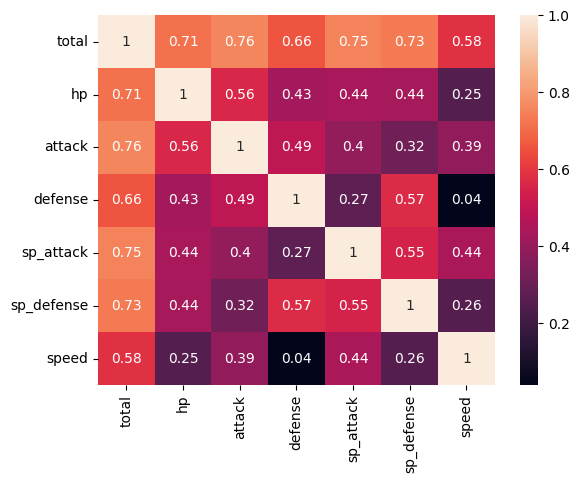

In [15]:
sns.heatmap(df.loc[:,'total':'speed'].corr(), annot=True)
plt.show()

En este caso, la variable 'total' claramente está corelacionada con todas las demás, y es un buen indicador de la 'calidad' del Pokémon, por lo tanto la mantendremos en nuestro análisis.

La variable 'sp_attack' tiene una correlación muy alta con 'sp_defense' y una buena correlación con'speed', por lo tanto, la escogemos en representación de estas dos variables.

Finalmente, la variable 'attack' tiene una correlación alta con 'hp' con 'defense', por lo cual también la escogemos.

Usando estas tres variables, con correlaciones altas, minimizamos la perdida de información. Almacenaremos estas variables en un nuevo Array de Numpy **con valores estandarizados** con el mismo orden en caso de que necesitemos revertir los cambios hechos luego del preprocesamiento.

La estandarización en este caso es importante, pues KMeans utiliza distancias para encontrar los clusters, y nuestras columnas tienen escalas diferentes. También podríamos aplicar una normalización.

In [16]:
from sklearn.preprocessing import StandardScaler


df_reduced = np.array(df[['total', 'attack', 'sp_attack']])
scaler = StandardScaler().fit(df_reduced)
df_reduced = scaler.transform(df_reduced)
print(df_reduced)

[[-1.36669641 -1.25236286 -1.01133158]
 [ 0.74840815  0.93317679 -0.39076797]
 [-1.49111432 -0.78403293 -1.16647248]
 ...
 [ 0.3751544  -0.15959303  0.85035925]
 [ 1.37049772  0.62095684  0.85035925]
 [-0.99344266 -0.47181298 -1.01133158]]


### 2.2 Número de clusters

El hiperparametro (configuración dada por el usuario) más importante para el modelo es el número de clusters que se van a generar. Hay múltiples maneras de determinar cuál es la cantidad apropiada de clusters, Aunque es una medida bastante subjetiva.

Para determinar esta medida, emplearemos varios métodos y compararemos los resultados.

Primero analizaremos la curva de codo, el estadístico de Gap, y la visualización de Dendrogramas

<Axes: >

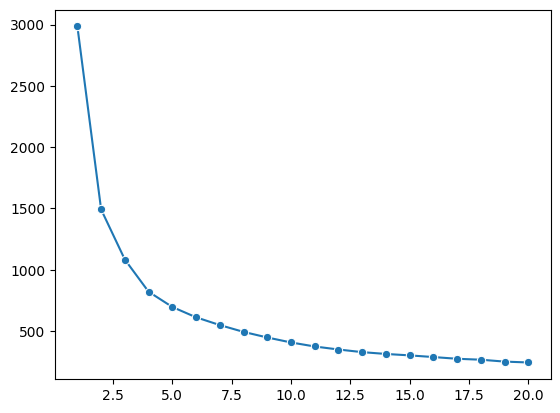

In [17]:
from sklearn.cluster import KMeans

inercias=[]

for i in range(1, 21):
  cluster = KMeans(n_clusters=i).fit(df_reduced)
  inercias.append(cluster.inertia_)

sns.lineplot(x=[i for i in range(1, 21)], y=inercias, marker='o')

El objetivo de la curva de codo es determinar el número de clusters a partir del cuál la ganancia de inercia (uno de los parámetros del modelo que nos muestra qué tan 'densos' son los clusters) deja de ser significativa. Para determinar esto, debemos encontrar el "codo" de la curva, el punto de cambio abrupto.

Esta medida es subjetiva, pero podemos ver que la ganancia deja de ser significativa alrededor del punto 4 o 5.

A continuación, utilizaremos una medida menos subjetiva: El estadístico de Gap.

El estadístico de Gap consiste en comparar la inercia del modelo con la inercia que tendría en el peor caso posible para un modelo de KMeans: una distribución uniformemente distribuída.

El siguiente código fue adaptado de:
https://www.analyticslane.com/2023/06/02/optimizar-el-numero-de-clusteres-con-gap-statistics/

In [18]:
def optimalK(data, nrefs=3, maxClusters=3):

    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        # guardara los resultados de dispersión de cada distribución simulada
        refDisps = np.zeros(nrefs)

        # Genera las muestras aleatorias indicadas con nrefs y ejecuta k-means
        # en cada bucle obteniendo los resultados de dispersión (inercia)
        # para cada conjunto generado.
        for i in range(nrefs):

            # Crea nuevo conjunto aleatorio de referencia
            # Se puede usar una semilla para tener reproducibilidad
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)

            # se ajusta el modelo al conjunto de referencia
            km = KMeans(k)
            km.fit(randomReference)
            # se guarda la dispersión obtenida
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Se ajusta el modelo a los datos originales y se guarda su inercia
        km = KMeans(k)
        km.fit(data)

        origDisp = km.inertia_

        # Calcula el estadístico de gap para k clusters usando el promedio de
        # las dispersiones de los datos simulados y la dispersión de los datos originales.
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Guarda el estadístico de gap obtenido en este bucle.
        gaps[gap_index] = gap

        temp_results = pd.DataFrame({'clusterCount':k, 'gap':gap}, index=[0])
        resultsdf = pd.concat([resultsdf, temp_results], ignore_index=True)

    # Selecciona el "primer máximo" de los estadísticos obtenidos y devuelve
    # su respectivo número de clusters
    for i in range(0, len(gaps)-1):
      if gaps[i+1] <= gaps[i]:
        return (i+1, resultsdf)
    return (len(gaps), resultsdf)

In [ ]:
optimal = optimalK(df_reduced, 3, 30)
sns.lineplot(x=optimal[1].clusterCount, y=optimal[1].gap, marker='o')
plt.show()

El número apropiado de clusters de acuerdo al estadístico de Gap es **el primer punto** donde la gráfica sea descendente, en este caso, 4.

Anteriormente usando el método del codo habíamos determinado que el número apropiado de clusters estaba entre 3 y 4, el estadístico de Gap nos indicó que el número apropiado de clusters es 4. Esta información parece apuntar a que el número apropiado de clusters sería 4, sin embargo, haremos una última comparación.

Un Dendrograma es un tipo de representación que aglomera los datos en categorías en base a la distancia euclidiana, similar a lo que hace KMeans. El problema es que un Dendrograma solo nos permite visualizar, no predecir.

Para analizar la cantidad de clusters apropiados en base al Dendrograma, buscaremos un área de la gráfica donde haya una distancia considerable sin uniones de categorías; esto nos demostrará que las categorías creadas son lo suficientemente diferentes.

In [ ]:
from scipy.cluster import hierarchy


values = hierarchy.linkage(df_reduced, method='complete')
fig, ax = plt.subplots()
dn = hierarchy.dendrogram(values, no_labels=True)
y1=4
y2=6
ax.fill_between([0, 10000], y1, y2, alpha=0.25, color='red')
plt.show()

En este caso, notamos que hay un gran área donde los datos son apropiadamente representados por 5, 4 y 3 categorías. El número de categorías que mayor distancia ocupa sin una nueva unión es el de 4 categorías.

Esto significa que si dividimos el Dataset en 4 Clusters, estos serán lo suficientemente diferentes de los demás para generar información útil.

Para recopilar la información que hemos adquirido:

* Con el método del codo determinamos que 3, 4 o 5 clusters serían ideales
* El método de Gap determinó que 4 clusters serían ideales
* EL Dendrograma mostró que los clusters serían suficientemente diferentes si se creásen 3, 4 o 5; siendo especialmente bueno en 4.

Los métodos subjetivos apuntaron a un valor entre tres y cinco, mientras el estadístico de Gap apuntó a 4. Considerando esto, **el valor que utilizaremos para entrenar el modelo será 4 clusters.**

### 2.3 Entrenamiento del Modelo

El entrenamiento del modelo consiste en el ajuste de múltiples hiperparametros en búsqueda del mejor ajuste. Las gráficas y métodos anteriores buscaban determinar el valor a usar para el parámetro más importante del modelo KMeans: n_clusters.

En este caso, y por simplicidad, este será el único parámetro que modificaremos. Una vez entrenemos el modelo pasaremos diréctamente a graficar los resultados (la gráfica 3D es interactiva, siéntase libre de explorarla).

In [ ]:
import plotly.express as px

mdl = KMeans(n_clusters=4).fit(df_reduced)

print('Representación gráfica de los clusters formados. \nX=total\nY=attack\nZ=sp_attack')

px.scatter_3d(x=df_reduced[:,0],
              y=df_reduced[:,1],
              z=df_reduced[:,2],
              color=mdl.labels_)

El modelo parecce segmentar bastante bien en base a las características que decidimos utilizar, por lo tanto, podríamos decir que logra su objetivo.

Para hacer un análisis más a fondo de los resultados del modelo, haremos una predicción sobre el dataset original (incluyendo los datos atípicos, y ordenados por generación, pues el modelo ya está entrenado así que el orden no importa).

In [ ]:
df_original['label'] = mdl.predict(
    scaler.transform(
        df_original[['total', 'attack', 'sp_attack']]
    ))
print(df_original.head())

## 3. Análisis de Clusters

Anteriormente, le agregamos al DataFrame inicial los cuatro clusters producidos por el modelo; ahora, analizaremos las características principales de estos clusters y las diferencias entre ellos.

Primero graficaremos las características de cada cluster.

In [ ]:
df_original_label0 = df_original[df_original['label'] == 0]
df_original_label0.loc[:,'hp':'speed'].hist(sharex=True, sharey=True)
plt.xlim(right=250)

plt.tight_layout()
plt.show()

In [ ]:
df_original_label1 = df_original[df_original['label'] == 1]
df_original_label1.loc[:,'hp':'speed'].hist(sharex=True, sharey=True)
plt.xlim(right=250)

plt.tight_layout()
plt.show()

In [ ]:
df_original_label2 = df_original[df_original['label'] == 2]
df_original_label2.loc[:,'hp':'speed'].hist(sharex=True, sharey=True)
plt.xlim(right=250)

plt.tight_layout()
plt.show()

In [ ]:
df_original_label3 = df_original[df_original['label'] == 3]
df_original_label3.loc[:,'hp':'speed'].hist(sharex=True, sharey=True)
plt.xlim(right=250)

plt.tight_layout()
plt.show()

En la siguiente tabla se muestran los promedios de cada estadística de combate, agrupados por los clusters dados por el modelo.

In [ ]:
print(df_original.loc[:,'total':'speed'].join(df_original['label'])\
      .groupby('label').mean().round(4))

De los clusters encontrados podemos evidenciar lo siguiente:

* El cluster número 0 contiene a Pokémones con características muy por encima del promedio; **todas** sus características son en promedio más altas que las de los otros tres clusters, en particular, su ataque, ataque especial y velocidad (características que determinan la capacidad ofensiva de los Pokémones) son extremadamente altas. Por lo tanto, podríamos catalogar a estos Pokémones como los **'excepcionales'** (es muy probable los legendarios se encuentren en este cluster).

* El cluster número 1 contiene Pokémones con características similares al cluster 3: su vida, velocidad y total son similares, sin embargo, su ataque y defensa son más altos, mientras su ataque especial y defensa especial son más bajos; Esto significa que estos Pokémones tienen un enfoque más físico. Es interesante observar que estos Pokémones alcanzan un ataque y defensa más altos que el ataque especial y defensa especial de sus contrapartes, pero tienen un ataque especial muy bajo. Considerando esto, este grupo será catalogado como los **'físicos'**.

* El cluster número 2 contiene a los Pokémones cuyo ataque especial es particularmente alto y tienen características generales altas. Al estar altamente correlacionados, el ataque especial, defensa especial y velocidad de estos Pokémones son altas, la defensa y vida tienen valores promedio y el ataque es ligeramente bajo; considerando lo anterior, estos Pokémones se podrían llamar los **'especiales'**.

* El cluster número 3 podría ser catalogado como el cluster de Pokémones **'débiles'**, pues contiene a aquellos con estadísticas totales considerablemente bajas, y que no resaltan en ningún ámbito en particular.

Actualizaremos los nombres de las etiquetas para reflejar esta nueva categorización.

In [ ]:
df_original['label'].replace({0:'excepcional', 1:'fisico', 2:'especial', 3:'debil'}, inplace=True)
df_original['label'] = df_original['label'].astype('category')
print(df_original.head())

## 4. Conclusiones

En base a los cuatro clusters encontrados por el modelo podemos analizar múltiples relaciones entre los datos y sus variables para sacar conclusiones generales sobre el dataset:

*  La categoría más numerosa es la 'débil', seguida de los especiales, los físicos, y los excepcionales en ese orden. Lo interesante es que la categoría de excepcionales tiene un número considerable de entradas para lo altas que son sus características. Esto significa que hay una cantidad relativamente alta de Pokémones fuertes, incluso si también hay muchos más débiles.

In [ ]:
print(df_original[['name', 'label']].groupby('label').count())

* Los Pokémones legendarios están mayormente concentrados en la categoría 'excepcional', sin embargo, no todos los Pokémones de este tipo se encuentran en esta categoría. Así mismo, hay Pokémones excepcionales que no son legendarios (incluso, tres legendarios se encuentran en la categoría 'debil').

Esto significa que hay Pokémones que, sin ser legendarios, tienen características lo suficientemente altas para pertenecer al mismo grupo que estos.

In [ ]:
print(df_original[['legendary', 'label']].groupby('label').value_counts())

* En general, los Pokémones con enfoque físico tienden a tener un ataque especial muy bajo, mientras los de enfoque especial tienen un ataque normal promedio, esto se puede deber a que los Pokémones físicos no requieren de habilidades especiales, pero los Pokémones especiales sí emplean habilidades físicas.

In [ ]:
print(df_original.loc[:,'total':'speed'].join(df_original['label'])\
      .groupby('label').mean().loc[['especial', 'fisico'],:].round(4))

*  Los Pokémones de tipo especial tienen al Pokémon con la vida más alta del juego. Los Pokémones débiles tienen a los Pokémon con mayor defensa y defensa especial del juego (aunque los físicos también tienen al menos un Pokémon con el valor más alto de defensa). Adicionalmente, los Pokémones físicos no tienen ningún Pokémon que resalte por su vida, aún cuando su valor promedio es más alto que en los especiales.

* Los excepcionales, por su parte, no tienen ningún Pokémon con extrema defensa ni defensa especial, pero sí tienen a los Pokémones con los valores de ataque, ataque especial y velocidad más altos del juego, superando en ataque a los Pokémones físicos, y en ataque especial a los especiales. Los Pokémones excepcionales parecen resaltar en estadísticas ofensivas, pero no necesariamente en defensivas.

In [ ]:
print(df_original.loc[:,'total':'speed'].join(df_original['label'])\
      .groupby('label').max())

* A diferencia de los legendarios, ninguna versión 'Mega' de un Pokémon está clasificada como débil, la mayoría son clasificados como excepcionales. De hecho, la categoría 'excepcional' está compuesta en total por 32 Pokémones Mega, 83 legendarios (como vimos antes), y 35 Pokémones comúnes (los restantes).

In [ ]:
print(df_original[df_original['name'].str.contains('Mega')]\
      .groupby('label')['name'].count())

---------

Este es el final de mis conclusiones, sin embargo, este DataSet permite experimentar y responder muchas más preguntas, por ejemplo ¿Qué tal se desempeñaría el modelo si se hubiesen escogido otras características para crearlo? o, ¿Qué tan diferentes serían los grupos si excluyeramos a los legendarios?, ¿Qué tal si hubiesemos usado más características?

Este proyecto solo responde unas pocas preguntas, te invito a experimentar diferentes combinaciones de características y buscar otro tipo de información nueva e interesante de este Dataset!